In [6]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.offsetbox import AnchoredText
import scipy.optimize
import pandas as pd

Tc=2/np.log(1+np.sqrt(2))
Ts=np.array([1.,Tc,3.])
Ns=[10000,30000,30000]
Ls=np.array([25,50,100])
T_eq=[100,400,1850]


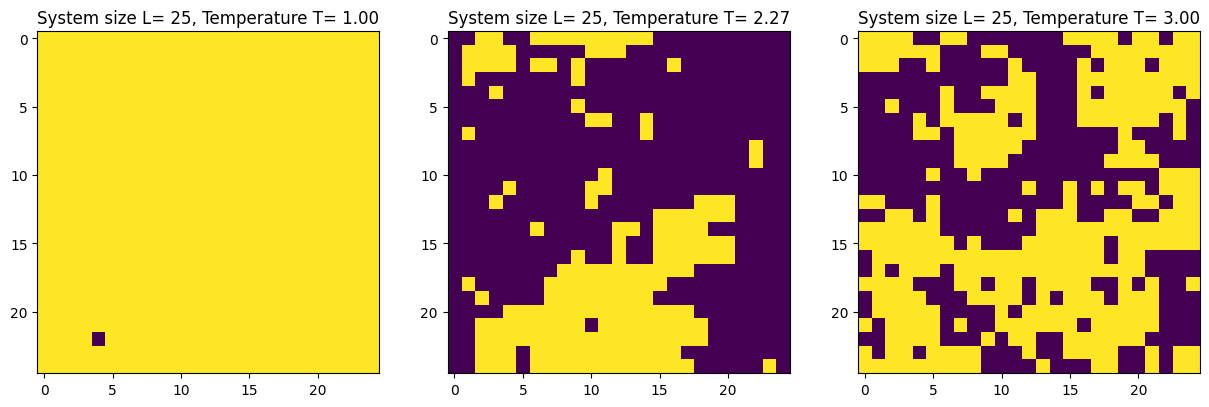

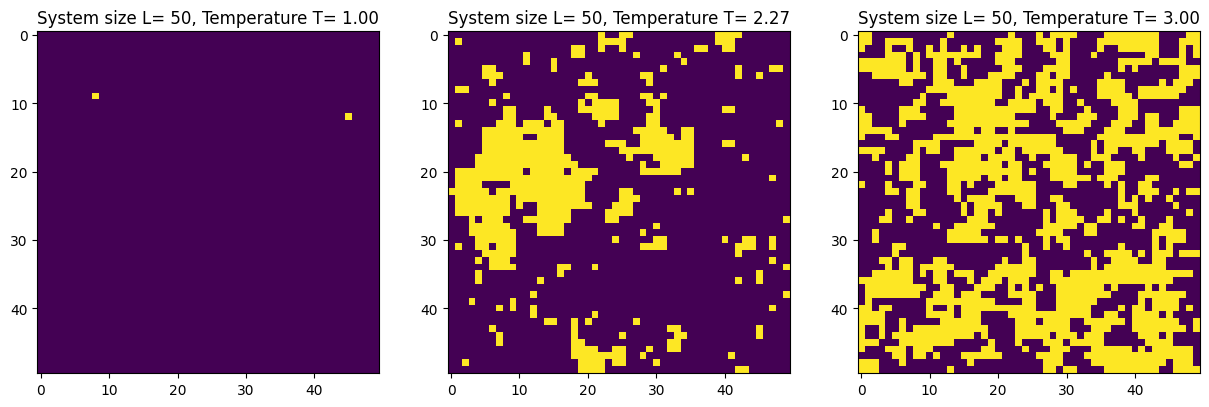

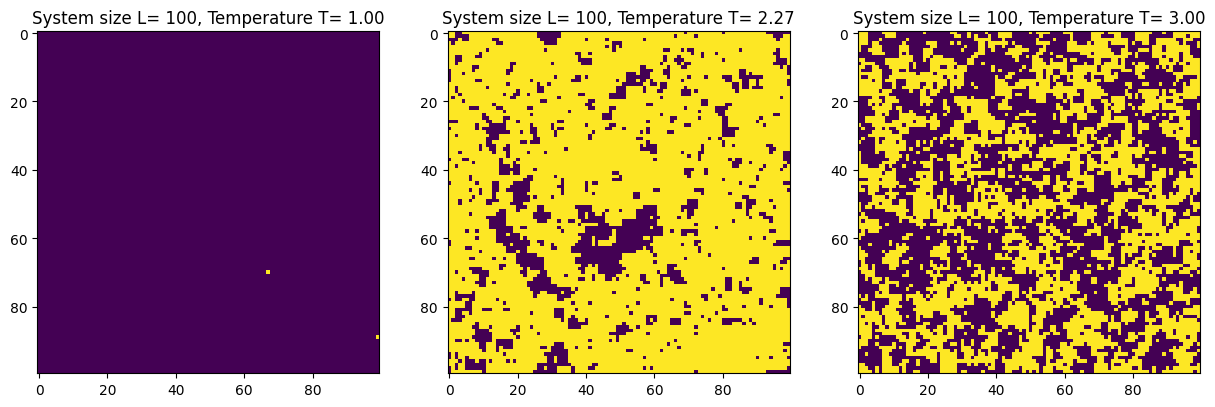

In [7]:
#read in the data from csv file
data = []
with open('Ising_models.csv') as csvfile:
    contents= csv.reader(csvfile, delimiter=";")
    #next(contents)#skip header line
    for row in contents:
        data.append(np.asarray(row).astype('int'))
k=0

for j, L in enumerate(Ls):
    fig,axs =plt.subplots(1,3,figsize=(15,5))

    for i,T in enumerate(Ts):
        Matrix= np.reshape(data[k],(L,L))
        axs[i].imshow(Matrix)
        k+=1
        axs[i].set_title("System size L= %d, Temperature T= %.2f"%(L,T))
    

Describe plots and expected behaviour, and what is plotted next

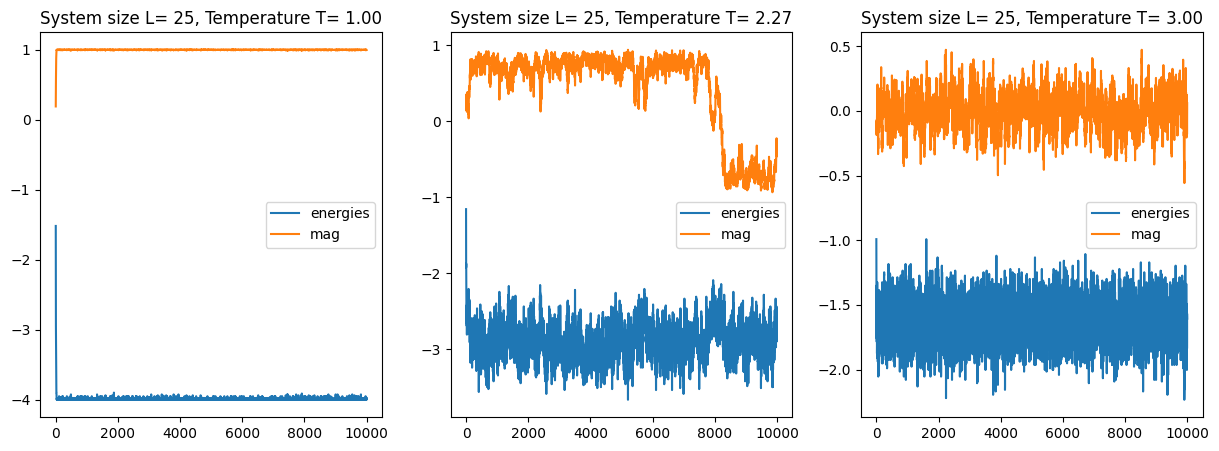

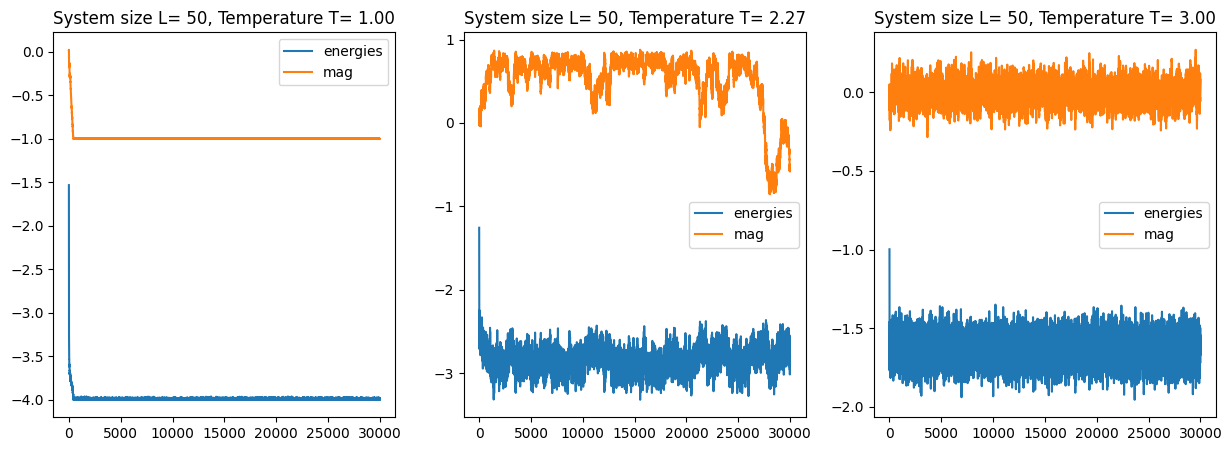

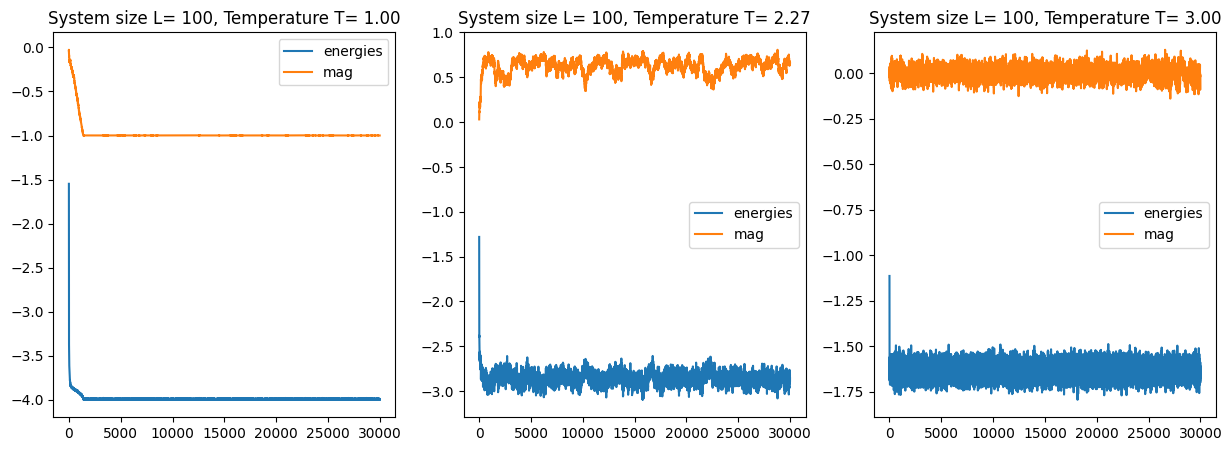

In [8]:
#read in the data from csv file
data = []
with open('Ising_data.csv') as csvfile:
    contents= csv.reader(csvfile, delimiter=";")
    next(contents)#skip header line
    for row in contents:
        data.append(np.asarray(row).astype('float64'))


k=0
for j, L in enumerate(Ls):
    fig,axs =plt.subplots(1,3,figsize=(15,5))
    N_range= np.arange(0,Ns[j])



    for i,T in enumerate(Ts):
        Magnetisations= data[k]
        k+=1
       
        Energies=data[k]
        k+=1
        axs[i].plot(N_range, Energies,label="energies")
        axs[i].plot(N_range, Magnetisations,label="mag")
        axs[i].legend()
        
        #axs[i].set_xlim(0,2000) #toggle on to have a look at origin to find equilibrium times
        #axs[i].set_ylim(-4.4,10)
        axs[i].set_title("System size L= %d, Temperature T= %.2f"%(L,T))
    #axs[0].vlines(T_eq[j],-4.3,4.3,ls="--",color="red")




Description of plots above and visiual det of equilibrium times

formulas for ensemble energy and mag
formulas for mag susc. and spec heat
results listed below along with errors

[[ 9.99246869e-01  4.45717010e-01  8.55272727e-04]
 [-9.99256054e-01  5.30676541e-01 -8.81432432e-04]
 [-9.99275517e-01  6.27976909e-01  1.81945293e-03]]


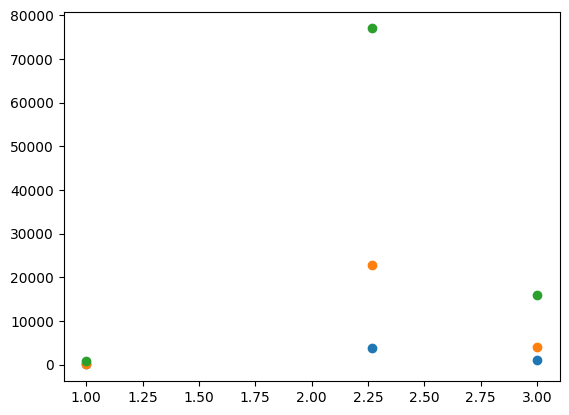

In [9]:


ensemble_magnetisations=np.empty((3,3))
ensemble_energies=np.empty((3,3))
mag_variances=np.empty((3,3))
en_variances=np.empty((3,3))
k=0
for j, L in enumerate(Ls):
    
    for i,T in enumerate(Ts):
        Magnetisations= data[k][T_eq[j]::]
        
        ensemble_magnetisations[j][i]=np.mean(Magnetisations)
        mag_variances[j][i]=np.var(Magnetisations)
        
        k+=1
       
        Energies=data[k][T_eq[j]::]
        k+=1
        ensemble_energies[j][i]=np.mean(Energies)
        en_variances[j][i]=np.var(Energies)
print(ensemble_magnetisations)

specific_heat1 = en_variances*Ls**4/Ts**2
specific_heat=np.empty((3,3))
specific_heat[0]= en_variances[0]*Ls[0]**4/Ts**2
specific_heat[1]= en_variances[1]*Ls[1]**4/Ts**2
specific_heat[2]= en_variances[2]*Ls[2]**4/Ts**2
mag_susceptibility = mag_variances/Ts
plt.scatter(Ts,specific_heat[0])
plt.scatter(Ts,specific_heat[1])
plt.scatter(Ts,specific_heat[2])




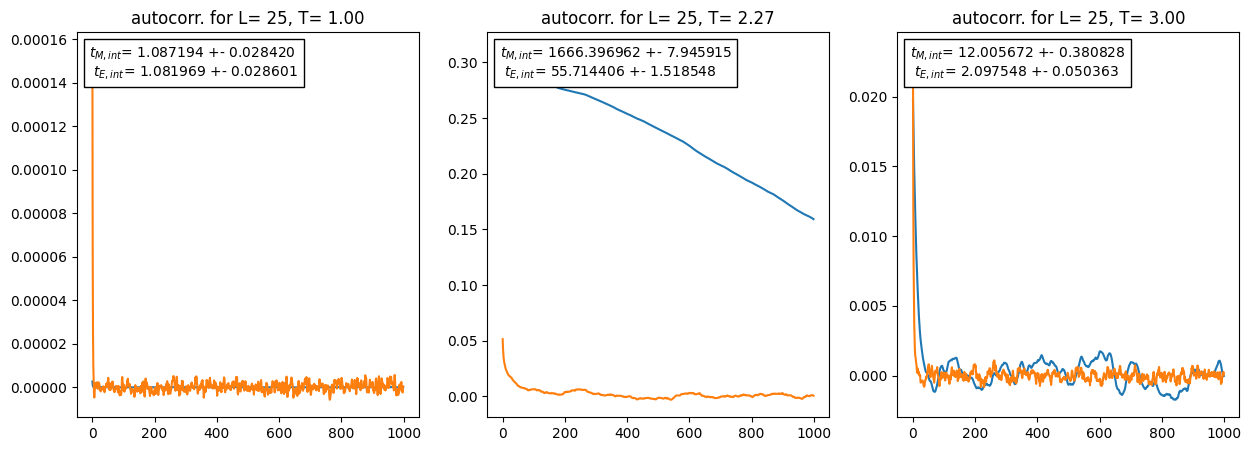

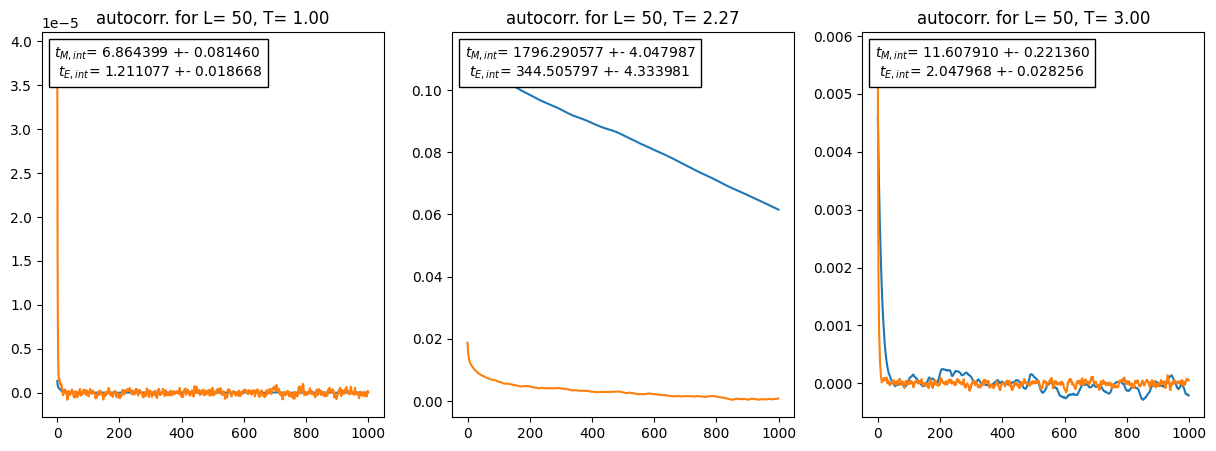

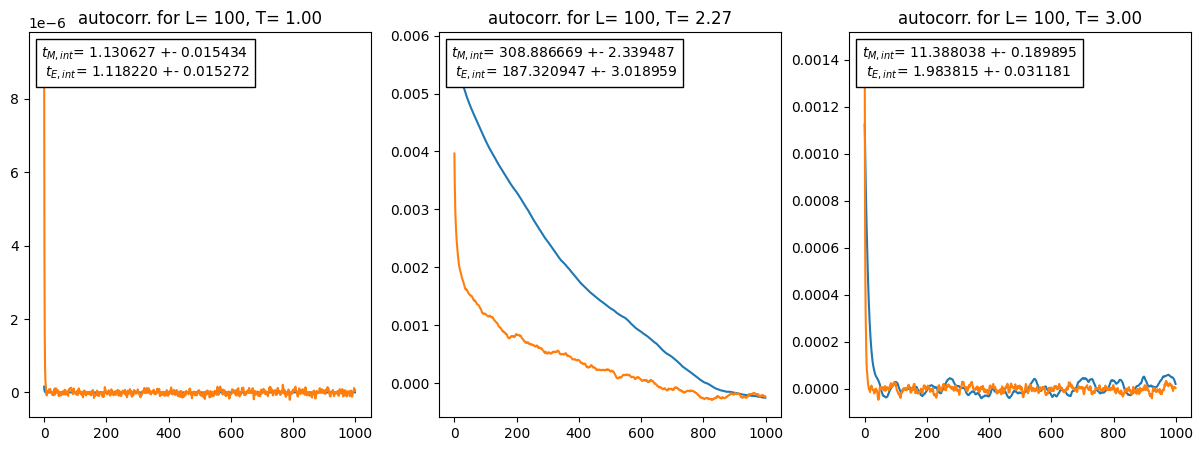

In [10]:
def exp(x,tau,a):
    return a*np.exp(-x/tau)

def calc_autocorrellation(array, lag_max, t_eq):
    array=array[t_eq::]
    array_centered= array-np.average(array)
    N_samples= len(array)
    autocov = np.empty(lag_max)
    lagtimes=np.arange(0,lag_max)
    for j in range(lag_max):
        autocov[j] = np.dot(array_centered[:N_samples - j],array_centered[j:])
    autocov /= (N_samples-lagtimes)
    return autocov
lagmax=1000
k=0
auto_times=[]
for j, L in enumerate(Ls):
    fig,axs =plt.subplots(1,3,figsize=(15,5))
    lagtimes=np.arange(0,lagmax)

    for i,T in enumerate(Ts):
        Mag_autocorr= calc_autocorrellation(data[k],lagmax,T_eq[j])
        popt1,pcov1=scipy.optimize.curve_fit(exp,lagtimes,Mag_autocorr)
        
        k+=1
        En_autocorr=calc_autocorrellation(data[k],lagmax,T_eq[j])
        popt2,pcov2=scipy.optimize.curve_fit(exp,lagtimes,En_autocorr)
        k+=1
        auto_times.append(popt2[0])
        anchored_text = AnchoredText("$t_{M,int}$= %f +- %f\n $t_{E,int}$= %f +- %f"%(popt1[0],np.sqrt(pcov1[0][0]),popt2[0],np.sqrt(pcov2[0][0])),loc=2)
        axs[i].plot(lagtimes,Mag_autocorr )
        axs[i].plot(lagtimes, En_autocorr)
        axs[i].add_artist(anchored_text)
        axs[i].set_title("autocorr. for L= %d, T= %.2f"%(L,T))
        #axs[i].set_yscale("log")


In [11]:
def S2_corr(observable,t_eq,t_corr):
    t_max=len(observable)
    return (1+2*t_corr)/(t_max-t_eq-1)*np.var(observable[t_eq:])
S2_corr_mags=[]
S2_corr_ens=[]

k=0
for j, L in enumerate(Ls):
    for i, T in enumerate(Ts):
        S2_corr_mags.append(S2_corr(data[k],T_eq[j],auto_times[3*j+i]))
        k+=1
      
        S2_corr_ens.append(S2_corr(data[k],T_eq[j],auto_times[3*j+i]))
        k+=1
        
print(ensemble_energies.flatten())
print(S2_corr_ens)
print(ensemble_magnetisations.flatten())
print(S2_corr_mags)

[-3.99410166 -2.90094804 -1.63298521 -3.99428876 -2.84602259 -1.63482368
 -3.99432261 -2.85629056 -1.6341554 ]
[4.956230240914808e-08, 0.0005844171700935449, 1.2260587966995708e-05, 4.513925370930088e-09, 0.00043724263559021854, 9.92113750458223e-07, 1.0737006004267019e-09, 5.29168353440807e-05, 2.5461556702323173e-07]
[ 9.99246869e-01  4.45717010e-01  8.55272727e-04 -9.99256054e-01
  5.30676541e-01 -8.81432432e-04 -9.99275517e-01  6.27976909e-01
  1.81945293e-03]
[8.389365768515113e-10, 0.003536865544667495, 1.0396735391180377e-05, 1.513865121656563e-10, 0.0026327175309602577, 7.940224768147707e-07, 1.809864560359063e-11, 7.680731218845533e-05, 1.9852710482932416e-07]


[]

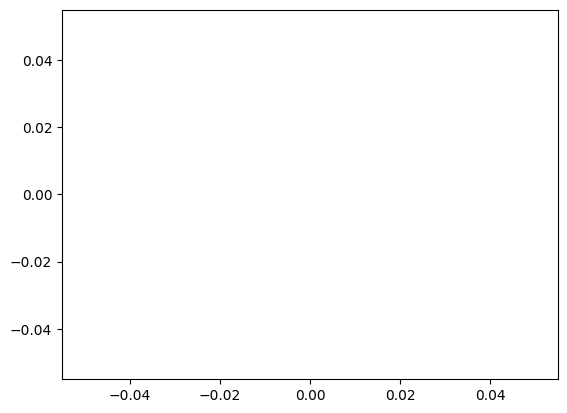

In [12]:
### Finite scale analysis
plt.plot()

